In [1]:
import torch
from utils.config import ModelConfig
from models.unet import UNetWithCrossAttention
from models.diffusion import Diffusion
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from utils.SoundDataset import SoundDataset
from torch.utils.data import DataLoader

In [2]:
def load_snapshot(snapshot_path, raw_model):
    snapshot = torch.load(snapshot_path)
    raw_model.load_state_dict(snapshot["MODEL_STATE"])
    train_noise_losses = snapshot["TRAIN_NOISE_LOSSES"]
    train_feature_losses = snapshot["TRAIN_FEATURE_LOSSES"]
    val_losses = snapshot["VAL_LOSSES"]
    lr = snapshot["LR"]

    return raw_model, train_noise_losses, train_feature_losses, val_losses, lr

In [3]:
image_path = "data/images"
sound_path = "data/sounds"

data = SoundDataset(image_path, sound_path)

val_loader = DataLoader(data, 
                        batch_size=3,
                        pin_memory=True,
                        shuffle=False, 
                        drop_last=True)

In [4]:
# from archisound import ArchiSound

device = "cuda" if torch.cuda.is_available() else "cpu"

# autoencoder = ArchiSound.from_pretrained("dmae1d-ATC64-v2").to(device)

from models.AudioEncoder import AudioEncoder

encode = AudioEncoder("facebook/wav2vec2-base-960h",
                                    device,
                                    48000)

/home/usr/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
config = ModelConfig({"image_size": 128, "audio_ctx_dim": 768})

# Инициализация
diffusion = Diffusion(timesteps=1000, image_size=128, device=device)
model = UNetWithCrossAttention(config)

In [6]:
model, train_noise_losses, train_feature_losses, val_losses, lr = load_snapshot("result.pt", model)
print(f"last lr = {lr}")

/tmp/ipykernel_65432/2821654118.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  snapshot = torch.load(snapshot_path)


RuntimeError: Error(s) in loading state_dict for UNetWithCrossAttention:
	Missing key(s) in state_dict: "time_embedding.linear_1.weight", "time_embedding.linear_1.bias", "time_embedding.linear_2.weight", "time_embedding.linear_2.bias", "unet.encoders.0.0.weight", "unet.encoders.0.0.bias", "unet.encoders.1.0.groupnorm_feature.weight", "unet.encoders.1.0.groupnorm_feature.bias", "unet.encoders.1.0.conv_feature.weight", "unet.encoders.1.0.conv_feature.bias", "unet.encoders.1.0.linear_time.weight", "unet.encoders.1.0.linear_time.bias", "unet.encoders.1.0.groupnorm_merged.weight", "unet.encoders.1.0.groupnorm_merged.bias", "unet.encoders.1.0.conv_merged.weight", "unet.encoders.1.0.conv_merged.bias", "unet.encoders.1.1.groupnorm.weight", "unet.encoders.1.1.groupnorm.bias", "unet.encoders.1.1.conv_input.weight", "unet.encoders.1.1.conv_input.bias", "unet.encoders.1.1.layernorm_2.weight", "unet.encoders.1.1.layernorm_2.bias", "unet.encoders.1.1.attention_2.q_proj.weight", "unet.encoders.1.1.attention_2.k_proj.weight", "unet.encoders.1.1.attention_2.v_proj.weight", "unet.encoders.1.1.attention_2.out_proj.weight", "unet.encoders.1.1.attention_2.out_proj.bias", "unet.encoders.1.1.layernorm_3.weight", "unet.encoders.1.1.layernorm_3.bias", "unet.encoders.1.1.linear_geglu_1.weight", "unet.encoders.1.1.linear_geglu_1.bias", "unet.encoders.1.1.linear_geglu_2.weight", "unet.encoders.1.1.linear_geglu_2.bias", "unet.encoders.1.1.conv_output.weight", "unet.encoders.1.1.conv_output.bias", "unet.encoders.2.0.groupnorm_feature.weight", "unet.encoders.2.0.groupnorm_feature.bias", "unet.encoders.2.0.conv_feature.weight", "unet.encoders.2.0.conv_feature.bias", "unet.encoders.2.0.linear_time.weight", "unet.encoders.2.0.linear_time.bias", "unet.encoders.2.0.groupnorm_merged.weight", "unet.encoders.2.0.groupnorm_merged.bias", "unet.encoders.2.0.conv_merged.weight", "unet.encoders.2.0.conv_merged.bias", "unet.encoders.2.1.groupnorm.weight", "unet.encoders.2.1.groupnorm.bias", "unet.encoders.2.1.conv_input.weight", "unet.encoders.2.1.conv_input.bias", "unet.encoders.2.1.layernorm_2.weight", "unet.encoders.2.1.layernorm_2.bias", "unet.encoders.2.1.attention_2.q_proj.weight", "unet.encoders.2.1.attention_2.k_proj.weight", "unet.encoders.2.1.attention_2.v_proj.weight", "unet.encoders.2.1.attention_2.out_proj.weight", "unet.encoders.2.1.attention_2.out_proj.bias", "unet.encoders.2.1.layernorm_3.weight", "unet.encoders.2.1.layernorm_3.bias", "unet.encoders.2.1.linear_geglu_1.weight", "unet.encoders.2.1.linear_geglu_1.bias", "unet.encoders.2.1.linear_geglu_2.weight", "unet.encoders.2.1.linear_geglu_2.bias", "unet.encoders.2.1.conv_output.weight", "unet.encoders.2.1.conv_output.bias", "unet.encoders.3.0.weight", "unet.encoders.3.0.bias", "unet.encoders.4.0.groupnorm_feature.weight", "unet.encoders.4.0.groupnorm_feature.bias", "unet.encoders.4.0.conv_feature.weight", "unet.encoders.4.0.conv_feature.bias", "unet.encoders.4.0.linear_time.weight", "unet.encoders.4.0.linear_time.bias", "unet.encoders.4.0.groupnorm_merged.weight", "unet.encoders.4.0.groupnorm_merged.bias", "unet.encoders.4.0.conv_merged.weight", "unet.encoders.4.0.conv_merged.bias", "unet.encoders.4.0.residual_layer.weight", "unet.encoders.4.0.residual_layer.bias", "unet.encoders.4.1.groupnorm.weight", "unet.encoders.4.1.groupnorm.bias", "unet.encoders.4.1.conv_input.weight", "unet.encoders.4.1.conv_input.bias", "unet.encoders.4.1.layernorm_1.weight", "unet.encoders.4.1.layernorm_1.bias", "unet.encoders.4.1.attention_1.in_proj.weight", "unet.encoders.4.1.attention_1.out_proj.weight", "unet.encoders.4.1.attention_1.out_proj.bias", "unet.encoders.4.1.layernorm_2.weight", "unet.encoders.4.1.layernorm_2.bias", "unet.encoders.4.1.attention_2.q_proj.weight", "unet.encoders.4.1.attention_2.k_proj.weight", "unet.encoders.4.1.attention_2.v_proj.weight", "unet.encoders.4.1.attention_2.out_proj.weight", "unet.encoders.4.1.attention_2.out_proj.bias", "unet.encoders.4.1.layernorm_3.weight", "unet.encoders.4.1.layernorm_3.bias", "unet.encoders.4.1.linear_geglu_1.weight", "unet.encoders.4.1.linear_geglu_1.bias", "unet.encoders.4.1.linear_geglu_2.weight", "unet.encoders.4.1.linear_geglu_2.bias", "unet.encoders.4.1.conv_output.weight", "unet.encoders.4.1.conv_output.bias", "unet.encoders.5.0.groupnorm_feature.weight", "unet.encoders.5.0.groupnorm_feature.bias", "unet.encoders.5.0.conv_feature.weight", "unet.encoders.5.0.conv_feature.bias", "unet.encoders.5.0.linear_time.weight", "unet.encoders.5.0.linear_time.bias", "unet.encoders.5.0.groupnorm_merged.weight", "unet.encoders.5.0.groupnorm_merged.bias", "unet.encoders.5.0.conv_merged.weight", "unet.encoders.5.0.conv_merged.bias", "unet.encoders.5.1.groupnorm.weight", "unet.encoders.5.1.groupnorm.bias", "unet.encoders.5.1.conv_input.weight", "unet.encoders.5.1.conv_input.bias", "unet.encoders.5.1.layernorm_1.weight", "unet.encoders.5.1.layernorm_1.bias", "unet.encoders.5.1.attention_1.in_proj.weight", "unet.encoders.5.1.attention_1.out_proj.weight", "unet.encoders.5.1.attention_1.out_proj.bias", "unet.encoders.5.1.layernorm_2.weight", "unet.encoders.5.1.layernorm_2.bias", "unet.encoders.5.1.attention_2.q_proj.weight", "unet.encoders.5.1.attention_2.k_proj.weight", "unet.encoders.5.1.attention_2.v_proj.weight", "unet.encoders.5.1.attention_2.out_proj.weight", "unet.encoders.5.1.attention_2.out_proj.bias", "unet.encoders.5.1.layernorm_3.weight", "unet.encoders.5.1.layernorm_3.bias", "unet.encoders.5.1.linear_geglu_1.weight", "unet.encoders.5.1.linear_geglu_1.bias", "unet.encoders.5.1.linear_geglu_2.weight", "unet.encoders.5.1.linear_geglu_2.bias", "unet.encoders.5.1.conv_output.weight", "unet.encoders.5.1.conv_output.bias", "unet.encoders.6.0.weight", "unet.encoders.6.0.bias", "unet.encoders.7.0.groupnorm_feature.weight", "unet.encoders.7.0.groupnorm_feature.bias", "unet.encoders.7.0.conv_feature.weight", "unet.encoders.7.0.conv_feature.bias", "unet.encoders.7.0.linear_time.weight", "unet.encoders.7.0.linear_time.bias", "unet.encoders.7.0.groupnorm_merged.weight", "unet.encoders.7.0.groupnorm_merged.bias", "unet.encoders.7.0.conv_merged.weight", "unet.encoders.7.0.conv_merged.bias", "unet.encoders.7.0.residual_layer.weight", "unet.encoders.7.0.residual_layer.bias", "unet.encoders.7.1.groupnorm.weight", "unet.encoders.7.1.groupnorm.bias", "unet.encoders.7.1.conv_input.weight", "unet.encoders.7.1.conv_input.bias", "unet.encoders.7.1.layernorm_1.weight", "unet.encoders.7.1.layernorm_1.bias", "unet.encoders.7.1.attention_1.in_proj.weight", "unet.encoders.7.1.attention_1.out_proj.weight", "unet.encoders.7.1.attention_1.out_proj.bias", "unet.encoders.7.1.layernorm_2.weight", "unet.encoders.7.1.layernorm_2.bias", "unet.encoders.7.1.attention_2.q_proj.weight", "unet.encoders.7.1.attention_2.k_proj.weight", "unet.encoders.7.1.attention_2.v_proj.weight", "unet.encoders.7.1.attention_2.out_proj.weight", "unet.encoders.7.1.attention_2.out_proj.bias", "unet.encoders.7.1.layernorm_3.weight", "unet.encoders.7.1.layernorm_3.bias", "unet.encoders.7.1.linear_geglu_1.weight", "unet.encoders.7.1.linear_geglu_1.bias", "unet.encoders.7.1.linear_geglu_2.weight", "unet.encoders.7.1.linear_geglu_2.bias", "unet.encoders.7.1.conv_output.weight", "unet.encoders.7.1.conv_output.bias", "unet.encoders.8.0.groupnorm_feature.weight", "unet.encoders.8.0.groupnorm_feature.bias", "unet.encoders.8.0.conv_feature.weight", "unet.encoders.8.0.conv_feature.bias", "unet.encoders.8.0.linear_time.weight", "unet.encoders.8.0.linear_time.bias", "unet.encoders.8.0.groupnorm_merged.weight", "unet.encoders.8.0.groupnorm_merged.bias", "unet.encoders.8.0.conv_merged.weight", "unet.encoders.8.0.conv_merged.bias", "unet.encoders.8.1.groupnorm.weight", "unet.encoders.8.1.groupnorm.bias", "unet.encoders.8.1.conv_input.weight", "unet.encoders.8.1.conv_input.bias", "unet.encoders.8.1.layernorm_1.weight", "unet.encoders.8.1.layernorm_1.bias", "unet.encoders.8.1.attention_1.in_proj.weight", "unet.encoders.8.1.attention_1.out_proj.weight", "unet.encoders.8.1.attention_1.out_proj.bias", "unet.encoders.8.1.layernorm_2.weight", "unet.encoders.8.1.layernorm_2.bias", "unet.encoders.8.1.attention_2.q_proj.weight", "unet.encoders.8.1.attention_2.k_proj.weight", "unet.encoders.8.1.attention_2.v_proj.weight", "unet.encoders.8.1.attention_2.out_proj.weight", "unet.encoders.8.1.attention_2.out_proj.bias", "unet.encoders.8.1.layernorm_3.weight", "unet.encoders.8.1.layernorm_3.bias", "unet.encoders.8.1.linear_geglu_1.weight", "unet.encoders.8.1.linear_geglu_1.bias", "unet.encoders.8.1.linear_geglu_2.weight", "unet.encoders.8.1.linear_geglu_2.bias", "unet.encoders.8.1.conv_output.weight", "unet.encoders.8.1.conv_output.bias", "unet.encoders.9.0.weight", "unet.encoders.9.0.bias", "unet.encoders.10.0.groupnorm_feature.weight", "unet.encoders.10.0.groupnorm_feature.bias", "unet.encoders.10.0.conv_feature.weight", "unet.encoders.10.0.conv_feature.bias", "unet.encoders.10.0.linear_time.weight", "unet.encoders.10.0.linear_time.bias", "unet.encoders.10.0.groupnorm_merged.weight", "unet.encoders.10.0.groupnorm_merged.bias", "unet.encoders.10.0.conv_merged.weight", "unet.encoders.10.0.conv_merged.bias", "unet.encoders.11.0.groupnorm_feature.weight", "unet.encoders.11.0.groupnorm_feature.bias", "unet.encoders.11.0.conv_feature.weight", "unet.encoders.11.0.conv_feature.bias", "unet.encoders.11.0.linear_time.weight", "unet.encoders.11.0.linear_time.bias", "unet.encoders.11.0.groupnorm_merged.weight", "unet.encoders.11.0.groupnorm_merged.bias", "unet.encoders.11.0.conv_merged.weight", "unet.encoders.11.0.conv_merged.bias", "unet.bottleneck.0.groupnorm_feature.weight", "unet.bottleneck.0.groupnorm_feature.bias", "unet.bottleneck.0.conv_feature.weight", "unet.bottleneck.0.conv_feature.bias", "unet.bottleneck.0.linear_time.weight", "unet.bottleneck.0.linear_time.bias", "unet.bottleneck.0.groupnorm_merged.weight", "unet.bottleneck.0.groupnorm_merged.bias", "unet.bottleneck.0.conv_merged.weight", "unet.bottleneck.0.conv_merged.bias", "unet.bottleneck.1.groupnorm.weight", "unet.bottleneck.1.groupnorm.bias", "unet.bottleneck.1.conv_input.weight", "unet.bottleneck.1.conv_input.bias", "unet.bottleneck.1.layernorm_1.weight", "unet.bottleneck.1.layernorm_1.bias", "unet.bottleneck.1.attention_1.in_proj.weight", "unet.bottleneck.1.attention_1.out_proj.weight", "unet.bottleneck.1.attention_1.out_proj.bias", "unet.bottleneck.1.layernorm_2.weight", "unet.bottleneck.1.layernorm_2.bias", "unet.bottleneck.1.attention_2.q_proj.weight", "unet.bottleneck.1.attention_2.k_proj.weight", "unet.bottleneck.1.attention_2.v_proj.weight", "unet.bottleneck.1.attention_2.out_proj.weight", "unet.bottleneck.1.attention_2.out_proj.bias", "unet.bottleneck.1.layernorm_3.weight", "unet.bottleneck.1.layernorm_3.bias", "unet.bottleneck.1.linear_geglu_1.weight", "unet.bottleneck.1.linear_geglu_1.bias", "unet.bottleneck.1.linear_geglu_2.weight", "unet.bottleneck.1.linear_geglu_2.bias", "unet.bottleneck.1.conv_output.weight", "unet.bottleneck.1.conv_output.bias", "unet.bottleneck.2.groupnorm_feature.weight", "unet.bottleneck.2.groupnorm_feature.bias", "unet.bottleneck.2.conv_feature.weight", "unet.bottleneck.2.conv_feature.bias", "unet.bottleneck.2.linear_time.weight", "unet.bottleneck.2.linear_time.bias", "unet.bottleneck.2.groupnorm_merged.weight", "unet.bottleneck.2.groupnorm_merged.bias", "unet.bottleneck.2.conv_merged.weight", "unet.bottleneck.2.conv_merged.bias", "unet.decoders.0.0.groupnorm_feature.weight", "unet.decoders.0.0.groupnorm_feature.bias", "unet.decoders.0.0.conv_feature.weight", "unet.decoders.0.0.conv_feature.bias", "unet.decoders.0.0.linear_time.weight", "unet.decoders.0.0.linear_time.bias", "unet.decoders.0.0.groupnorm_merged.weight", "unet.decoders.0.0.groupnorm_merged.bias", "unet.decoders.0.0.conv_merged.weight", "unet.decoders.0.0.conv_merged.bias", "unet.decoders.0.0.residual_layer.weight", "unet.decoders.0.0.residual_layer.bias", "unet.decoders.1.0.groupnorm_feature.weight", "unet.decoders.1.0.groupnorm_feature.bias", "unet.decoders.1.0.conv_feature.weight", "unet.decoders.1.0.conv_feature.bias", "unet.decoders.1.0.linear_time.weight", "unet.decoders.1.0.linear_time.bias", "unet.decoders.1.0.groupnorm_merged.weight", "unet.decoders.1.0.groupnorm_merged.bias", "unet.decoders.1.0.conv_merged.weight", "unet.decoders.1.0.conv_merged.bias", "unet.decoders.1.0.residual_layer.weight", "unet.decoders.1.0.residual_layer.bias", "unet.decoders.2.0.groupnorm_feature.weight", "unet.decoders.2.0.groupnorm_feature.bias", "unet.decoders.2.0.conv_feature.weight", "unet.decoders.2.0.conv_feature.bias", "unet.decoders.2.0.linear_time.weight", "unet.decoders.2.0.linear_time.bias", "unet.decoders.2.0.groupnorm_merged.weight", "unet.decoders.2.0.groupnorm_merged.bias", "unet.decoders.2.0.conv_merged.weight", "unet.decoders.2.0.conv_merged.bias", "unet.decoders.2.0.residual_layer.weight", "unet.decoders.2.0.residual_layer.bias", "unet.decoders.2.1.conv.weight", "unet.decoders.2.1.conv.bias", "unet.decoders.3.0.groupnorm_feature.weight", "unet.decoders.3.0.groupnorm_feature.bias", "unet.decoders.3.0.conv_feature.weight", "unet.decoders.3.0.conv_feature.bias", "unet.decoders.3.0.linear_time.weight", "unet.decoders.3.0.linear_time.bias", "unet.decoders.3.0.groupnorm_merged.weight", "unet.decoders.3.0.groupnorm_merged.bias", "unet.decoders.3.0.conv_merged.weight", "unet.decoders.3.0.conv_merged.bias", "unet.decoders.3.0.residual_layer.weight", "unet.decoders.3.0.residual_layer.bias", "unet.decoders.3.1.groupnorm.weight", "unet.decoders.3.1.groupnorm.bias", "unet.decoders.3.1.conv_input.weight", "unet.decoders.3.1.conv_input.bias", "unet.decoders.3.1.layernorm_1.weight", "unet.decoders.3.1.layernorm_1.bias", "unet.decoders.3.1.attention_1.in_proj.weight", "unet.decoders.3.1.attention_1.out_proj.weight", "unet.decoders.3.1.attention_1.out_proj.bias", "unet.decoders.3.1.layernorm_2.weight", "unet.decoders.3.1.layernorm_2.bias", "unet.decoders.3.1.attention_2.q_proj.weight", "unet.decoders.3.1.attention_2.k_proj.weight", "unet.decoders.3.1.attention_2.v_proj.weight", "unet.decoders.3.1.attention_2.out_proj.weight", "unet.decoders.3.1.attention_2.out_proj.bias", "unet.decoders.3.1.layernorm_3.weight", "unet.decoders.3.1.layernorm_3.bias", "unet.decoders.3.1.linear_geglu_1.weight", "unet.decoders.3.1.linear_geglu_1.bias", "unet.decoders.3.1.linear_geglu_2.weight", "unet.decoders.3.1.linear_geglu_2.bias", "unet.decoders.3.1.conv_output.weight", "unet.decoders.3.1.conv_output.bias", "unet.decoders.4.0.groupnorm_feature.weight", "unet.decoders.4.0.groupnorm_feature.bias", "unet.decoders.4.0.conv_feature.weight", "unet.decoders.4.0.conv_feature.bias", "unet.decoders.4.0.linear_time.weight", "unet.decoders.4.0.linear_time.bias", "unet.decoders.4.0.groupnorm_merged.weight", "unet.decoders.4.0.groupnorm_merged.bias", "unet.decoders.4.0.conv_merged.weight", "unet.decoders.4.0.conv_merged.bias", "unet.decoders.4.0.residual_layer.weight", "unet.decoders.4.0.residual_layer.bias", "unet.decoders.4.1.groupnorm.weight", "unet.decoders.4.1.groupnorm.bias", "unet.decoders.4.1.conv_input.weight", "unet.decoders.4.1.conv_input.bias", "unet.decoders.4.1.layernorm_1.weight", "unet.decoders.4.1.layernorm_1.bias", "unet.decoders.4.1.attention_1.in_proj.weight", "unet.decoders.4.1.attention_1.out_proj.weight", "unet.decoders.4.1.attention_1.out_proj.bias", "unet.decoders.4.1.layernorm_2.weight", "unet.decoders.4.1.layernorm_2.bias", "unet.decoders.4.1.attention_2.q_proj.weight", "unet.decoders.4.1.attention_2.k_proj.weight", "unet.decoders.4.1.attention_2.v_proj.weight", "unet.decoders.4.1.attention_2.out_proj.weight", "unet.decoders.4.1.attention_2.out_proj.bias", "unet.decoders.4.1.layernorm_3.weight", "unet.decoders.4.1.layernorm_3.bias", "unet.decoders.4.1.linear_geglu_1.weight", "unet.decoders.4.1.linear_geglu_1.bias", "unet.decoders.4.1.linear_geglu_2.weight", "unet.decoders.4.1.linear_geglu_2.bias", "unet.decoders.4.1.conv_output.weight", "unet.decoders.4.1.conv_output.bias", "unet.decoders.5.0.groupnorm_feature.weight", "unet.decoders.5.0.groupnorm_feature.bias", "unet.decoders.5.0.conv_feature.weight", "unet.decoders.5.0.conv_feature.bias", "unet.decoders.5.0.linear_time.weight", "unet.decoders.5.0.linear_time.bias", "unet.decoders.5.0.groupnorm_merged.weight", "unet.decoders.5.0.groupnorm_merged.bias", "unet.decoders.5.0.conv_merged.weight", "unet.decoders.5.0.conv_merged.bias", "unet.decoders.5.0.residual_layer.weight", "unet.decoders.5.0.residual_layer.bias", "unet.decoders.5.1.groupnorm.weight", "unet.decoders.5.1.groupnorm.bias", "unet.decoders.5.1.conv_input.weight", "unet.decoders.5.1.conv_input.bias", "unet.decoders.5.1.layernorm_1.weight", "unet.decoders.5.1.layernorm_1.bias", "unet.decoders.5.1.attention_1.in_proj.weight", "unet.decoders.5.1.attention_1.out_proj.weight", "unet.decoders.5.1.attention_1.out_proj.bias", "unet.decoders.5.1.layernorm_2.weight", "unet.decoders.5.1.layernorm_2.bias", "unet.decoders.5.1.attention_2.q_proj.weight", "unet.decoders.5.1.attention_2.k_proj.weight", "unet.decoders.5.1.attention_2.v_proj.weight", "unet.decoders.5.1.attention_2.out_proj.weight", "unet.decoders.5.1.attention_2.out_proj.bias", "unet.decoders.5.1.layernorm_3.weight", "unet.decoders.5.1.layernorm_3.bias", "unet.decoders.5.1.linear_geglu_1.weight", "unet.decoders.5.1.linear_geglu_1.bias", "unet.decoders.5.1.linear_geglu_2.weight", "unet.decoders.5.1.linear_geglu_2.bias", "unet.decoders.5.1.conv_output.weight", "unet.decoders.5.1.conv_output.bias", "unet.decoders.5.2.conv.weight", "unet.decoders.5.2.conv.bias", "unet.decoders.6.0.groupnorm_feature.weight", "unet.decoders.6.0.groupnorm_feature.bias", "unet.decoders.6.0.conv_feature.weight", "unet.decoders.6.0.conv_feature.bias", "unet.decoders.6.0.linear_time.weight", "unet.decoders.6.0.linear_time.bias", "unet.decoders.6.0.groupnorm_merged.weight", "unet.decoders.6.0.groupnorm_merged.bias", "unet.decoders.6.0.conv_merged.weight", "unet.decoders.6.0.conv_merged.bias", "unet.decoders.6.0.residual_layer.weight", "unet.decoders.6.0.residual_layer.bias", "unet.decoders.6.1.groupnorm.weight", "unet.decoders.6.1.groupnorm.bias", "unet.decoders.6.1.conv_input.weight", "unet.decoders.6.1.conv_input.bias", "unet.decoders.6.1.layernorm_1.weight", "unet.decoders.6.1.layernorm_1.bias", "unet.decoders.6.1.attention_1.in_proj.weight", "unet.decoders.6.1.attention_1.out_proj.weight", "unet.decoders.6.1.attention_1.out_proj.bias", "unet.decoders.6.1.layernorm_2.weight", "unet.decoders.6.1.layernorm_2.bias", "unet.decoders.6.1.attention_2.q_proj.weight", "unet.decoders.6.1.attention_2.k_proj.weight", "unet.decoders.6.1.attention_2.v_proj.weight", "unet.decoders.6.1.attention_2.out_proj.weight", "unet.decoders.6.1.attention_2.out_proj.bias", "unet.decoders.6.1.layernorm_3.weight", "unet.decoders.6.1.layernorm_3.bias", "unet.decoders.6.1.linear_geglu_1.weight", "unet.decoders.6.1.linear_geglu_1.bias", "unet.decoders.6.1.linear_geglu_2.weight", "unet.decoders.6.1.linear_geglu_2.bias", "unet.decoders.6.1.conv_output.weight", "unet.decoders.6.1.conv_output.bias", "unet.decoders.7.0.groupnorm_feature.weight", "unet.decoders.7.0.groupnorm_feature.bias", "unet.decoders.7.0.conv_feature.weight", "unet.decoders.7.0.conv_feature.bias", "unet.decoders.7.0.linear_time.weight", "unet.decoders.7.0.linear_time.bias", "unet.decoders.7.0.groupnorm_merged.weight", "unet.decoders.7.0.groupnorm_merged.bias", "unet.decoders.7.0.conv_merged.weight", "unet.decoders.7.0.conv_merged.bias", "unet.decoders.7.0.residual_layer.weight", "unet.decoders.7.0.residual_layer.bias", "unet.decoders.7.1.groupnorm.weight", "unet.decoders.7.1.groupnorm.bias", "unet.decoders.7.1.conv_input.weight", "unet.decoders.7.1.conv_input.bias", "unet.decoders.7.1.layernorm_1.weight", "unet.decoders.7.1.layernorm_1.bias", "unet.decoders.7.1.attention_1.in_proj.weight", "unet.decoders.7.1.attention_1.out_proj.weight", "unet.decoders.7.1.attention_1.out_proj.bias", "unet.decoders.7.1.layernorm_2.weight", "unet.decoders.7.1.layernorm_2.bias", "unet.decoders.7.1.attention_2.q_proj.weight", "unet.decoders.7.1.attention_2.k_proj.weight", "unet.decoders.7.1.attention_2.v_proj.weight", "unet.decoders.7.1.attention_2.out_proj.weight", "unet.decoders.7.1.attention_2.out_proj.bias", "unet.decoders.7.1.layernorm_3.weight", "unet.decoders.7.1.layernorm_3.bias", "unet.decoders.7.1.linear_geglu_1.weight", "unet.decoders.7.1.linear_geglu_1.bias", "unet.decoders.7.1.linear_geglu_2.weight", "unet.decoders.7.1.linear_geglu_2.bias", "unet.decoders.7.1.conv_output.weight", "unet.decoders.7.1.conv_output.bias", "unet.decoders.8.0.groupnorm_feature.weight", "unet.decoders.8.0.groupnorm_feature.bias", "unet.decoders.8.0.conv_feature.weight", "unet.decoders.8.0.conv_feature.bias", "unet.decoders.8.0.linear_time.weight", "unet.decoders.8.0.linear_time.bias", "unet.decoders.8.0.groupnorm_merged.weight", "unet.decoders.8.0.groupnorm_merged.bias", "unet.decoders.8.0.conv_merged.weight", "unet.decoders.8.0.conv_merged.bias", "unet.decoders.8.0.residual_layer.weight", "unet.decoders.8.0.residual_layer.bias", "unet.decoders.8.1.groupnorm.weight", "unet.decoders.8.1.groupnorm.bias", "unet.decoders.8.1.conv_input.weight", "unet.decoders.8.1.conv_input.bias", "unet.decoders.8.1.layernorm_1.weight", "unet.decoders.8.1.layernorm_1.bias", "unet.decoders.8.1.attention_1.in_proj.weight", "unet.decoders.8.1.attention_1.out_proj.weight", "unet.decoders.8.1.attention_1.out_proj.bias", "unet.decoders.8.1.layernorm_2.weight", "unet.decoders.8.1.layernorm_2.bias", "unet.decoders.8.1.attention_2.q_proj.weight", "unet.decoders.8.1.attention_2.k_proj.weight", "unet.decoders.8.1.attention_2.v_proj.weight", "unet.decoders.8.1.attention_2.out_proj.weight", "unet.decoders.8.1.attention_2.out_proj.bias", "unet.decoders.8.1.layernorm_3.weight", "unet.decoders.8.1.layernorm_3.bias", "unet.decoders.8.1.linear_geglu_1.weight", "unet.decoders.8.1.linear_geglu_1.bias", "unet.decoders.8.1.linear_geglu_2.weight", "unet.decoders.8.1.linear_geglu_2.bias", "unet.decoders.8.1.conv_output.weight", "unet.decoders.8.1.conv_output.bias", "unet.decoders.8.2.conv.weight", "unet.decoders.8.2.conv.bias", "unet.decoders.9.0.groupnorm_feature.weight", "unet.decoders.9.0.groupnorm_feature.bias", "unet.decoders.9.0.conv_feature.weight", "unet.decoders.9.0.conv_feature.bias", "unet.decoders.9.0.linear_time.weight", "unet.decoders.9.0.linear_time.bias", "unet.decoders.9.0.groupnorm_merged.weight", "unet.decoders.9.0.groupnorm_merged.bias", "unet.decoders.9.0.conv_merged.weight", "unet.decoders.9.0.conv_merged.bias", "unet.decoders.9.0.residual_layer.weight", "unet.decoders.9.0.residual_layer.bias", "unet.decoders.9.1.groupnorm.weight", "unet.decoders.9.1.groupnorm.bias", "unet.decoders.9.1.conv_input.weight", "unet.decoders.9.1.conv_input.bias", "unet.decoders.9.1.layernorm_2.weight", "unet.decoders.9.1.layernorm_2.bias", "unet.decoders.9.1.attention_2.q_proj.weight", "unet.decoders.9.1.attention_2.k_proj.weight", "unet.decoders.9.1.attention_2.v_proj.weight", "unet.decoders.9.1.attention_2.out_proj.weight", "unet.decoders.9.1.attention_2.out_proj.bias", "unet.decoders.9.1.layernorm_3.weight", "unet.decoders.9.1.layernorm_3.bias", "unet.decoders.9.1.linear_geglu_1.weight", "unet.decoders.9.1.linear_geglu_1.bias", "unet.decoders.9.1.linear_geglu_2.weight", "unet.decoders.9.1.linear_geglu_2.bias", "unet.decoders.9.1.conv_output.weight", "unet.decoders.9.1.conv_output.bias", "unet.decoders.10.0.groupnorm_feature.weight", "unet.decoders.10.0.groupnorm_feature.bias", "unet.decoders.10.0.conv_feature.weight", "unet.decoders.10.0.conv_feature.bias", "unet.decoders.10.0.linear_time.weight", "unet.decoders.10.0.linear_time.bias", "unet.decoders.10.0.groupnorm_merged.weight", "unet.decoders.10.0.groupnorm_merged.bias", "unet.decoders.10.0.conv_merged.weight", "unet.decoders.10.0.conv_merged.bias", "unet.decoders.10.0.residual_layer.weight", "unet.decoders.10.0.residual_layer.bias", "unet.decoders.11.0.groupnorm_feature.weight", "unet.decoders.11.0.groupnorm_feature.bias", "unet.decoders.11.0.conv_feature.weight", "unet.decoders.11.0.conv_feature.bias", "unet.decoders.11.0.linear_time.weight", "unet.decoders.11.0.linear_time.bias", "unet.decoders.11.0.groupnorm_merged.weight", "unet.decoders.11.0.groupnorm_merged.bias", "unet.decoders.11.0.conv_merged.weight", "unet.decoders.11.0.conv_merged.bias", "unet.decoders.11.0.residual_layer.weight", "unet.decoders.11.0.residual_layer.bias", "final.groupnorm.weight", "final.groupnorm.bias", "final.conv.weight", "final.conv.bias". 
	Unexpected key(s) in state_dict: "down_blocks.0.conv1.weight", "down_blocks.0.conv1.bias", "down_blocks.0.conv2.weight", "down_blocks.0.conv2.bias", "down_blocks.0.BN1.weight", "down_blocks.0.BN1.bias", "down_blocks.0.BN1.running_mean", "down_blocks.0.BN1.running_var", "down_blocks.0.BN1.num_batches_tracked", "down_blocks.0.downsample.weight", "down_blocks.0.downsample.bias", "down_blocks.0.time_embed.0.weight", "down_blocks.0.time_embed.0.bias", "down_blocks.0.time_embed.2.weight", "down_blocks.0.time_embed.2.bias", "down_blocks.1.conv1.weight", "down_blocks.1.conv1.bias", "down_blocks.1.conv2.weight", "down_blocks.1.conv2.bias", "down_blocks.1.BN1.weight", "down_blocks.1.BN1.bias", "down_blocks.1.BN1.running_mean", "down_blocks.1.BN1.running_var", "down_blocks.1.BN1.num_batches_tracked", "down_blocks.1.downsample.weight", "down_blocks.1.downsample.bias", "down_blocks.1.time_embed.0.weight", "down_blocks.1.time_embed.0.bias", "down_blocks.1.time_embed.2.weight", "down_blocks.1.time_embed.2.bias", "down_blocks.2.conv1.weight", "down_blocks.2.conv1.bias", "down_blocks.2.conv2.weight", "down_blocks.2.conv2.bias", "down_blocks.2.BN1.weight", "down_blocks.2.BN1.bias", "down_blocks.2.BN1.running_mean", "down_blocks.2.BN1.running_var", "down_blocks.2.BN1.num_batches_tracked", "down_blocks.2.downsample.weight", "down_blocks.2.downsample.bias", "down_blocks.2.time_embed.0.weight", "down_blocks.2.time_embed.0.bias", "down_blocks.2.time_embed.2.weight", "down_blocks.2.time_embed.2.bias", "down_blocks.3.conv1.weight", "down_blocks.3.conv1.bias", "down_blocks.3.conv2.weight", "down_blocks.3.conv2.bias", "down_blocks.3.BN1.weight", "down_blocks.3.BN1.bias", "down_blocks.3.BN1.running_mean", "down_blocks.3.BN1.running_var", "down_blocks.3.BN1.num_batches_tracked", "down_blocks.3.downsample.weight", "down_blocks.3.downsample.bias", "down_blocks.3.time_embed.0.weight", "down_blocks.3.time_embed.0.bias", "down_blocks.3.time_embed.2.weight", "down_blocks.3.time_embed.2.bias", "mid_block_half.conv1.weight", "mid_block_half.conv1.bias", "mid_block_half.BN1.weight", "mid_block_half.BN1.bias", "mid_block_half.BN1.running_mean", "mid_block_half.BN1.running_var", "mid_block_half.BN1.num_batches_tracked", "mid_block_half.attn.W_Q.weight", "mid_block_half.attn.W_Q.bias", "mid_block_half.attn.W_K.weight", "mid_block_half.attn.W_K.bias", "mid_block_half.attn.W_V.weight", "mid_block_half.attn.W_V.bias", "mid_block_half.BN2.weight", "mid_block_half.BN2.bias", "mid_block_half.BN2.running_mean", "mid_block_half.BN2.running_var", "mid_block_half.BN2.num_batches_tracked", "mid_block_half.conv2.weight", "mid_block_half.conv2.bias", "mid_block_bot.conv1.weight", "mid_block_bot.conv1.bias", "mid_block_bot.BN1.weight", "mid_block_bot.BN1.bias", "mid_block_bot.BN1.running_mean", "mid_block_bot.BN1.running_var", "mid_block_bot.BN1.num_batches_tracked", "mid_block_bot.attn.W_Q.weight", "mid_block_bot.attn.W_Q.bias", "mid_block_bot.attn.W_K.weight", "mid_block_bot.attn.W_K.bias", "mid_block_bot.attn.W_V.weight", "mid_block_bot.attn.W_V.bias", "mid_block_bot.BN2.weight", "mid_block_bot.BN2.bias", "mid_block_bot.BN2.running_mean", "mid_block_bot.BN2.running_var", "mid_block_bot.BN2.num_batches_tracked", "mid_block_bot.conv2.weight", "mid_block_bot.conv2.bias", "up_blocks.0.upsample.weight", "up_blocks.0.upsample.bias", "up_blocks.0.conv1.weight", "up_blocks.0.conv1.bias", "up_blocks.0.BN1.weight", "up_blocks.0.BN1.bias", "up_blocks.0.BN1.running_mean", "up_blocks.0.BN1.running_var", "up_blocks.0.BN1.num_batches_tracked", "up_blocks.0.conv2.weight", "up_blocks.0.conv2.bias", "up_blocks.0.time_embed.0.weight", "up_blocks.0.time_embed.0.bias", "up_blocks.0.time_embed.2.weight", "up_blocks.0.time_embed.2.bias", "up_blocks.1.upsample.weight", "up_blocks.1.upsample.bias", "up_blocks.1.conv1.weight", "up_blocks.1.conv1.bias", "up_blocks.1.BN1.weight", "up_blocks.1.BN1.bias", "up_blocks.1.BN1.running_mean", "up_blocks.1.BN1.running_var", "up_blocks.1.BN1.num_batches_tracked", "up_blocks.1.conv2.weight", "up_blocks.1.conv2.bias", "up_blocks.1.time_embed.0.weight", "up_blocks.1.time_embed.0.bias", "up_blocks.1.time_embed.2.weight", "up_blocks.1.time_embed.2.bias", "up_blocks.2.upsample.weight", "up_blocks.2.upsample.bias", "up_blocks.2.conv1.weight", "up_blocks.2.conv1.bias", "up_blocks.2.BN1.weight", "up_blocks.2.BN1.bias", "up_blocks.2.BN1.running_mean", "up_blocks.2.BN1.running_var", "up_blocks.2.BN1.num_batches_tracked", "up_blocks.2.conv2.weight", "up_blocks.2.conv2.bias", "up_blocks.2.time_embed.0.weight", "up_blocks.2.time_embed.0.bias", "up_blocks.2.time_embed.2.weight", "up_blocks.2.time_embed.2.bias", "up_blocks.3.upsample.weight", "up_blocks.3.upsample.bias", "up_blocks.3.conv1.weight", "up_blocks.3.conv1.bias", "up_blocks.3.BN1.weight", "up_blocks.3.BN1.bias", "up_blocks.3.BN1.running_mean", "up_blocks.3.BN1.running_var", "up_blocks.3.BN1.num_batches_tracked", "up_blocks.3.conv2.weight", "up_blocks.3.conv2.bias", "up_blocks.3.time_embed.0.weight", "up_blocks.3.time_embed.0.bias", "up_blocks.3.time_embed.2.weight", "up_blocks.3.time_embed.2.bias". 

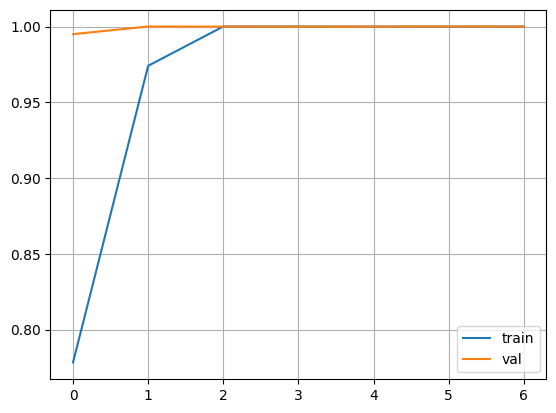

In [7]:
plt.plot(train_noise_losses[:], label='train: noise')
plt.plot(train_feature_losses[:], label='train: features')
plt.plot(val_losses[:], label='validation')
plt.grid()
plt.legend()

In [8]:
audio,image = next(iter(val_loader))
audio_embeds = encode(audio.to(device))

model.to(device)
model.eval()
generated_image = diffusion.reverse_process(
    model,
    audio_embeds,
    guidance_scale=7.5,
    batch_size=8,
    use_ddim=True,
    timesteps=100  #число шагов
)

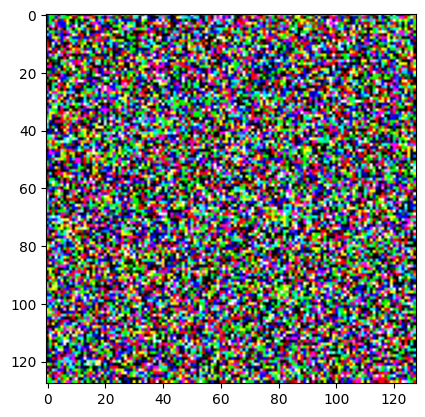

In [9]:
plt.imshow(torch.permute(generated_image[0].cpu(), (1,2,0)).numpy())

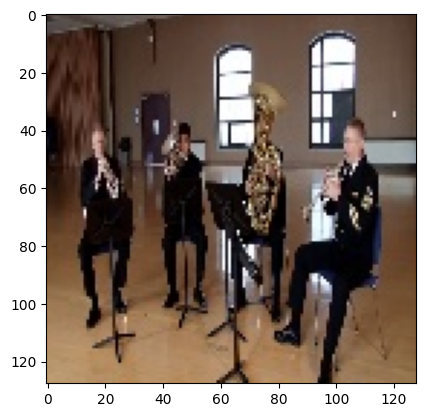

In [10]:
plt.imshow(torch.permute(image[0], (1,2,0)))

In [11]:
# модель сошлась на lr=0.0005 на 30 эпохах. Потери составили ~0.68
# размерность UNet:
# DownBlock(3, 32, 0.3),
# DownBlock(32, 64, 0.3),
# DownBlock(64, 128, 0.3),
# DownBlock(128, 256, 0.3)

# попробуем увеличить размер UNet в 2 раза:
# результатом стали точно такие же потери.
# Изменили финальную функцию активации на Tanh:
# на 16 эпохах получили потери 0.31
# на 32 эпохах потери составили чуть меньше 0.30 

# заменим все функции активации на tanh и повторим эксперимент
# экспиримент провалился, потери составили 0.35

# необходимо провести значительную отимизацию всего сценария обучения:
#   1. Вычислить эмбединги всех звуковых файлов и сфоримровать на их основе новый датасет
#   2. На основе более быстрого сценария провести обучение на большом числе эпох ~100
# Результат: потери в 0.29 на 120 эпохах

# снова увеличили модель в 2 раза, потери на 40 эпохах составили 0.28
# попробуем значительно увеличить вероятность безусловного обучения до 0.4 и продолжить обучение

# изменили модель добавив большее механизмов перекрестного внимания и самовнимания.
# после обучения на 5 эпохах получили потери в 0.23
# таже модель на 10 эпохах дала 0.22

# увеличили модель в 2 раза - полнный првал, потери ~1.0
# откатываемся к прежней архитектуре и пробуем реализовать Self-Perceptual loss